# **FULL DATASET BINARY**

### **Preliminary steps**

In [1]:
import os 
print(os.getcwd())
os.chdir('../..')
print(os.getcwd())

/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp/analysis/notebooks
/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp


In [149]:
### PACKAGES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [150]:
### FUNCTIONS

from src.configs import constants, ml_config, names
from src.libs import preprocessing, evaluation, visualization

In [151]:
import importlib
importlib.reload(preprocessing)

<module 'src.libs.preprocessing' from '/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp/src/libs/preprocessing.py'>

In [152]:
### LOAD DATA

df_poetry_gpt = preprocessing.load_dataset(source="GPT", type="POETRY")
df_poetry_bard = preprocessing.load_dataset(source="BARD", type="POETRY")
df_poetry_human = preprocessing.load_dataset(source="Human", type="POETRY")

df_essay_gpt = preprocessing.load_dataset(source="GPT", type="ESSAY")
df_essay_bard = preprocessing.load_dataset(source="BARD", type="ESSAY")
df_essay_human = preprocessing.load_dataset(source="Human", type="ESSAY")

df_story_gpt = preprocessing.load_dataset(source="GPT", type="STORY")
df_story_bard = preprocessing.load_dataset(source="BARD", type="STORY")
df_story_human = preprocessing.load_dataset(source="Human", type="STORY")

Time taken to load dataset: 0.030750036239624023 seconds
Time taken to load dataset: 0.009341001510620117 seconds
Time taken to load dataset: 0.3131837844848633 seconds
Time taken to load dataset: 0.009473085403442383 seconds
Time taken to load dataset: 0.036267995834350586 seconds
Time taken to load dataset: 0.09334301948547363 seconds
Time taken to load dataset: 0.01294088363647461 seconds
Time taken to load dataset: 0.01282811164855957 seconds
Time taken to load dataset: 0.01211404800415039 seconds


In [153]:
### GROUPED LLM 
df_poetry = preprocessing.get_poetry_dataset(
        df_poetry_gpt,
        df_poetry_bard,
        df_poetry_human,
        samples_per_source=min(
            len(df_poetry_gpt),
            len(df_poetry_bard),
            len(df_poetry_human),
        ),
    )

df_essay = preprocessing.get_essay_dataset(
        df_essay_gpt,
        df_essay_bard,
        df_essay_human,
        samples_per_source=min(
            len(df_essay_gpt), len(df_essay_bard), len(df_essay_human)
        ),
    )

df_story = preprocessing.get_story_dataset(
        df_story_gpt,
        df_story_bard,
        df_story_human,
        samples_per_source=min(
            len(df_story_gpt), len(df_story_bard), len(df_story_human)
        ),
    )


# ### GROUPED LLM 
# df_poetry = preprocessing.get_poetry_dataset(
#         df_poetry_gpt,
#         df_poetry_bard,
#         df_poetry_human,
#         samples_per_source=None,
#     )

# df_essay = preprocessing.get_essay_dataset(
#         df_essay_gpt,
#         df_essay_bard,
#         df_essay_human,
#         samples_per_source=None,
#     )

# df_story = preprocessing.get_story_dataset(
#         df_story_gpt,
#         df_story_bard,
#         df_story_human,
#         samples_per_source=None,
#     )



In [154]:
def group_llm(df):
    df["origin"] = df["label"]
    df["label"] = (df["label"] > 0).astype(int)
    return df

In [155]:
### GROUP 
df_poetry = group_llm(df_poetry)
df_essay = group_llm(df_essay)
df_story = group_llm(df_story)

In [156]:
### GET TRAIN SPLIT

df_train_poetry, df_test_poetry = preprocessing.train_valid_split(df_poetry)
df_train_essay, df_test_essay = preprocessing.train_valid_split(df_essay)
df_train_story, df_test_story = preprocessing.train_valid_split(df_story)

df_train_poetry_gpt, df_test_poetry_gpt = df_train_poetry[df_train_poetry.label==1].copy(), df_test_poetry[df_test_poetry.label==1].copy()
df_train_poetry_bard, df_test_poetry_bard = df_train_poetry[df_train_poetry.label==2].copy(), df_test_poetry[df_test_poetry.label==2].copy()
df_train_poetry_human, df_test_poetry_human = df_train_poetry[df_train_poetry.label==0].copy(), df_test_poetry[df_test_poetry.label==0].copy()


df_train_story_gpt, df_test_story_gpt = df_train_story[df_train_story.label==1].copy(), df_test_story[df_test_story.label==1].copy()
df_train_story_bard, df_test_story_bard = df_train_story[df_train_story.label==2].copy(), df_test_story[df_test_story.label==2].copy()
df_train_story_human, df_test_story_human = df_train_story[df_train_story.label==0].copy(), df_test_story[df_test_story.label==0].copy()

df_train_essay_gpt, df_test_essay_gpt = df_train_essay[df_train_essay.label==1].copy(), df_test_essay[df_test_essay.label==1].copy()
df_train_essay_bard, df_test_essay_bard = df_train_essay[df_train_essay.label==2].copy(), df_test_essay[df_test_essay.label==2].copy()
df_train_essay_human, df_test_essay_human = df_train_essay[df_train_essay.label==0].copy(), df_test_essay[df_test_essay.label==0].copy()

In [157]:
### CONCATENATE ALL DATASETS

df_train = pd.concat([df_train_poetry, df_train_essay, df_train_story], axis=0).sample(
    frac=1
)
df_test = pd.concat([df_test_poetry, df_test_essay, df_test_story], axis=0).sample(
    frac=1
)

In [158]:
### SPLIT FEATURES AND LABELS

X_train, y_train = preprocessing.split_features_and_labels(df_train)
X_test, y_test = preprocessing.split_features_and_labels(df_test)
X_test_poetry, y_test_poetry = preprocessing.split_features_and_labels(df_test_poetry)
X_test_essay, y_test_essay = preprocessing.split_features_and_labels(df_test_essay)
X_test_story, y_test_story = preprocessing.split_features_and_labels(df_test_story)

## **CLASSIFICATION USING PUNCTUATION & RANDOM FOREST**

In [159]:
df_train_essay.label.value_counts(), df_test_essay.label.value_counts()

(label
 1    355
 0    179
 Name: count, dtype: int64,
 label
 1    41
 0    19
 Name: count, dtype: int64)

In [160]:
df_train_poetry.label.value_counts(), df_test_poetry.label.value_counts()

(label
 1    444
 0    231
 Name: count, dtype: int64,
 label
 1    56
 0    19
 Name: count, dtype: int64)

In [161]:
df_train_story.label.value_counts(), df_test_story.label.value_counts()

(label
 1    173
 0     83
 Name: count, dtype: int64,
 label
 1    17
 0    12
 Name: count, dtype: int64)

In [162]:
def punctuation_transform(X: np.ndarray) -> np.ndarray:

    X_series = pd.Series(X).astype(str)
    array_nb_characters = X_series.str.len().to_numpy()

    array_ratio_punctuations = (
        X_series.str.count(r"[^\w\s]").to_numpy() / array_nb_characters
    )
    array_ratio_words_per_sentence = (
        X_series.str.count(r"[.!?]").to_numpy()
        / X_series.str.split().str.len().to_numpy()
    )
    array_ratio_odd_characters = (
        X_series.str.count(r"[!;-_]").to_numpy() / array_nb_characters
    )

    embedding = pd.DataFrame(
        {
            "ratio_punctuations": array_ratio_punctuations,
            "ratio_words_per_sentence": array_ratio_words_per_sentence,
            "ratio_odd_characters": array_ratio_odd_characters,
        }
    ).to_numpy()

    return embedding

def punctuation_map_dimensions_to_names() -> np.ndarray:
    return np.array([
        "ratio_punctuations",
        "ratio_words_per_sentence",
        "ratio_odd_characters"
    ])


In [163]:
### EMBEDDING

X_train_211 = punctuation_transform(X_train)
X_test_211 = punctuation_transform(X_test)
X_test_poetry_211 = punctuation_transform(X_test_poetry)
X_test_essay_211 = punctuation_transform(X_test_essay)
X_test_story_211 = punctuation_transform(X_test_story)

In [164]:
def evaluate(model, X, y):
    """
    Evaluate a model and return confusion matrix + precision, recall, f1.

    Args:
        model: Trained sklearn-like model.
        X (np.ndarray): Input features.
        y (np.ndarray): True labels.

    Returns:
        dict: Dictionary containing confusion matrix, precision, recall, f1 score.
    """
    y_pred = model.predict(X)

    return {
        "confusion_matrix": confusion_matrix(y, y_pred),
        "precision": precision_score(y, y_pred, average="binary"),
        "recall": recall_score(y, y_pred, average="binary"),
        "f1": f1_score(y, y_pred, average="binary")
    }


In [165]:
### Random search 

param_distributions = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "bootstrap": [True, False],
}

base_rf = RandomForestClassifier(n_jobs=-1, random_state=42)


search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_211, y_train)

best_rf = search.best_estimator_

print("Best hyperparameters:", search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


In [166]:
### CLASSIFIER

best_rf.fit(X_train_211, y_train)


# Evaluation
metrics_211 = evaluate(best_rf, X_test_211, y_test)
metrics_poetry_211 = evaluate(best_rf, X_test_poetry_211, y_test_poetry)
metrics_essay_211 = evaluate(best_rf, X_test_essay_211, y_test_essay)
metrics_story_211 = evaluate(best_rf, X_test_story_211, y_test_story)

results = {
    "test": metrics_211,
    "poetry": metrics_poetry_211,
    "essay": metrics_essay_211,
    "story": metrics_story_211
}
df_metrics = pd.DataFrame(results).T 
print(df_metrics.round(3)) 


             confusion_matrix precision    recall        f1
test    [[37, 13], [10, 104]]  0.888889  0.912281  0.900433
poetry     [[17, 2], [2, 54]]  0.964286  0.964286  0.964286
essay      [[14, 5], [6, 35]]     0.875  0.853659  0.864198
story       [[6, 6], [2, 15]]  0.714286  0.882353  0.789474


In [167]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_211 = punctuation_map_dimensions_to_names()
feature_importances_211 = best_rf.feature_importances_

most_important_features_211 = np.argsort(feature_importances_211)[-10:][::-1]

for i in most_important_features_211:
    print(f"{dim_names_211[i]}: {feature_importances_211[i]}")


ratio_words_per_sentence: 0.3810455354636022
ratio_odd_characters: 0.3326809009518996
ratio_punctuations: 0.2862735635844983


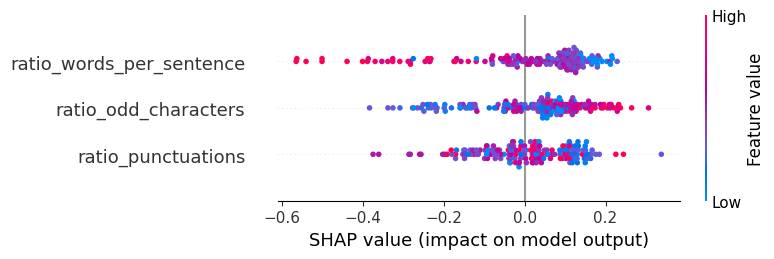

In [168]:
### INTERPRETABILITY - SHAP VALUES

explainer_211 = shap.Explainer(best_rf)
X_test_211_dense = X_test_211
shap_values_211 = explainer_211(X_test_211_dense)

shap.summary_plot(
    shap_values_211.values[:, :, 1], 
    features=X_test_211_dense,
    feature_names=dim_names_211
)

## **CLASSIFICATION USING TF-IDF & RANDOM FOREST**

In [169]:
def fit_tfidf_embedding(X_train_texts, max_features=1000):
    """
    Fit a TF-IDF vectorizer on training texts.

    Args:
        X_train_texts (list or np.ndarray): Training texts.
        max_features (int): Maximum number of features for TF-IDF.

    Returns:
        vectorizer: Fitted TfidfVectorizer instance.
        X_train_tfidf: Transformed training data.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        smooth_idf=True,
        stop_words="english"
    )
    X_train_tfidf = vectorizer.fit_transform(X_train_texts)
    return vectorizer, X_train_tfidf

def transform_with_tfidf(vectorizer, X_texts):
    """
    Transform texts using an already fitted TF-IDF vectorizer.

    Args:
        vectorizer: A fitted TfidfVectorizer.
        X_texts (list or np.ndarray): Texts to transform.

    Returns:
        X_tfidf: Transformed TF-IDF matrix.
    """
    return vectorizer.transform(X_texts)


In [170]:
### TF-IDF embedding
vectorizer_tfidf, X_train_tfidf = fit_tfidf_embedding(X_train, max_features=1000)

X_test_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test)
X_test_poetry_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_poetry)
X_test_essay_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_essay)
X_test_story_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_story)

In [171]:
base_rf = RandomForestClassifier(n_jobs=-1, random_state=42)


search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_tfidf, y_train)

best_rf_tfidf = search.best_estimator_

print("Best hyperparameters:", search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


In [172]:
### CLASSIFIER

best_rf_tfidf.fit(X_train_tfidf, y_train)

# Evaluation
metrics_tfidf = evaluate(best_rf_tfidf, X_test_tfidf, y_test)
metrics_poetry_tfidf = evaluate(best_rf_tfidf, X_test_poetry_tfidf, y_test_poetry)
metrics_essay_tfidf = evaluate(best_rf_tfidf, X_test_essay_tfidf, y_test_essay)
metrics_story_tfidf = evaluate(best_rf_tfidf, X_test_story_tfidf, y_test_story)

results = {
    "test": metrics_tfidf,
    "poetry": metrics_poetry_tfidf,
    "essay": metrics_essay_tfidf,
    "story": metrics_story_tfidf
}
df_metrics = pd.DataFrame(results).T 
print(df_metrics.round(3)) 


           confusion_matrix precision    recall        f1
test    [[44, 6], [1, 113]]   0.94958  0.991228  0.969957
poetry   [[15, 4], [0, 56]]  0.933333       1.0  0.965517
essay    [[19, 0], [0, 41]]       1.0       1.0       1.0
story    [[10, 2], [1, 16]]  0.888889  0.941176  0.914286


In [173]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_tfidf = vectorizer_tfidf.get_feature_names_out()
feature_importances_tfidf = best_rf_tfidf.feature_importances_
most_important_features_tfidf = np.argsort(feature_importances_tfidf)[-20:][::-1]
for i in most_important_features_tfidf:
    print(f"{dim_names_tfidf[i]}: {feature_importances_tfidf[i]:.5f}")


really: 0.03088
like: 0.02777
just: 0.02721
room: 0.01834
think: 0.01597
half: 0.01518
man: 0.01509
minutes: 0.01431
got: 0.01428
going: 0.01422
says: 0.01338
don: 0.01306
mother: 0.01303
father: 0.01180
help: 0.01112
right: 0.01059
head: 0.01028
dead: 0.01022
say: 0.00981
did: 0.00874


In [174]:
df_train

,text,abstract,label,type,origin
447,Two people of different interests and backgrou...,Explain how two people of different interests...,1,essay,1
18,"Chaos Chaos is the dance of the universe, A sw...",write a poetry about chaos,1,poetry,2
311,Well I'm finally getting around doing the writ...,No abstract,0,essay,0
120,The year is 2042. Dreams are now a commodity. ...,Imagine a world where dreams can be traded and...,1,story,2
152,"As an AI language model, I don't have personal...",Discuss the events in the life of your favori...,1,essay,1
...,...,...,...,...,...
123,Sibling rivalry is a common problem in familie...,Brothers and sisters do not always get along...,1,essay,2
338,When Emperor Hirohito announced Japan’s defeat...,\r\r\n From “understory”\r\...,0,poetry,0
423,One among the shifting mass of humanity intent...,\r\r\n Inclement\r\r\n ...,0,poetry,0
397,"The island I hate, you ask me why? It's a plac...",write a poem about an island you hate,1,poetry,1


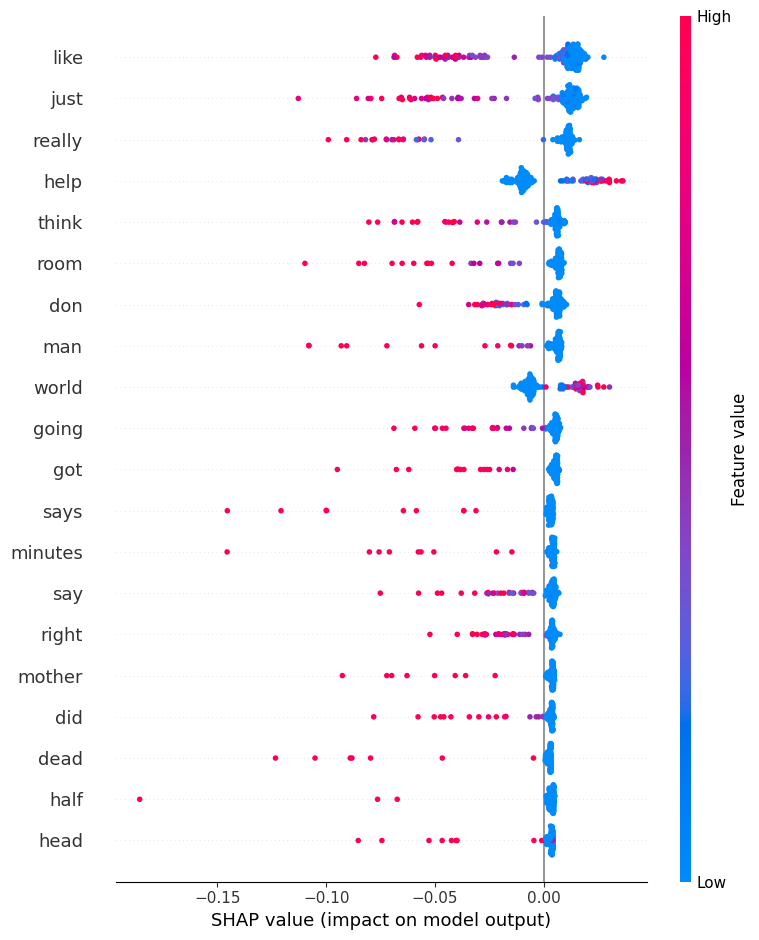

In [175]:
### INTERPRETABILITY - SHAP VALUES

X_test_tfidf_dense = X_test_tfidf.toarray()
explainer_tfidf = shap.TreeExplainer(best_rf_tfidf)
shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)

shap.summary_plot(
    shap_values_tfidf[:,:,1],
    features=X_test_tfidf_dense,
    feature_names=dim_names_tfidf
)


## **CLASSIFICATION USING TF-IDF & NAIVE BAYES**

In [176]:
### TF-IDF embedding
vectorizer_tfidf, X_train_tfidf = fit_tfidf_embedding(X_train, max_features=1000)

X_test_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test)
X_test_poetry_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_poetry)
X_test_essay_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_essay)
X_test_story_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_story)

In [177]:
### CLASSIFIER

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

metrics_tfidf = evaluate(nb_classifier, X_test_tfidf, y_test)
metrics_poetry_tfidf = evaluate(nb_classifier, X_test_poetry_tfidf, y_test_poetry)
metrics_essay_tfidf = evaluate(nb_classifier, X_test_essay_tfidf, y_test_essay)
metrics_story_tfidf = evaluate(nb_classifier, X_test_story_tfidf, y_test_story)

results = {
    "test": metrics_tfidf,
    "poetry": metrics_poetry_tfidf,
    "essay": metrics_essay_tfidf,
    "story": metrics_story_tfidf
}
df_metrics = pd.DataFrame(results).T 
print(df_metrics.round(3)) 


           confusion_matrix precision    recall        f1
test    [[46, 4], [6, 108]]  0.964286  0.947368  0.955752
poetry   [[16, 3], [0, 56]]  0.949153       1.0  0.973913
essay    [[19, 0], [1, 40]]       1.0   0.97561  0.987654
story    [[11, 1], [5, 12]]  0.923077  0.705882       0.8
